打开任何一本地震数据处理的教材，都会有正常时差校正(Normal-Moveout Corrention)的章节。我们对共中心点剖面应用NMO可将双曲型的反射剖面校正为水平剖面，但是课本上只是列出公式，具体怎么做呢？

$$
t_0^2 = t^2 - \frac{x^2}{v_{NMO}^2}
$$

这里，$v_{NMO}$ 为NMO 速度，$x$ 为炮点和接收点之间的距离（offset），$v$ 为反射界面之上的地层速度。$t_0$ 为垂直路线MD的双程旅行时。只有反射界面为水平时，深度点D在地表的投影才与中心点M重合。

![CMP](http://wiki.seg.org/images/d/df/Ch03_fig1-1.png)


上述公式将走时联系在一起，我们可以测量的$t$ 以及我们想知道的$t_0$。
但实际上，CMP道集的数据是时间t和offset函数的振幅矩阵。NMO校正后的道集同样如此。
因此我们做NMO校正实际上是将一种振幅转换为另一种振幅，但是我们的公式中却压根儿没有振幅！！

这就是公式和实际实现NMO校正的差异。

In [1]:
%matplotlib inline
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
data = np.load('data/synthetic_cmp.npz')
print("Data in the archive:", data.keys())

('Data in the archive:', ['dt', 'offsets', 'CMP'])


In [3]:
dt = data['dt']
offsets = data['offsets']
cmp = data['CMP']
nsamples = cmp.shape[0]
noffsets = cmp.shape[1]
print('dt = {} s'.format(dt))
print('offsets =', offsets)
print('N samples = {}'.format(nsamples))
print('N offsets = {}'.format(noffsets))

dt = 0.000456783919598 s
('offsets =', array([120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900]))
N samples = 1200
N offsets = 14


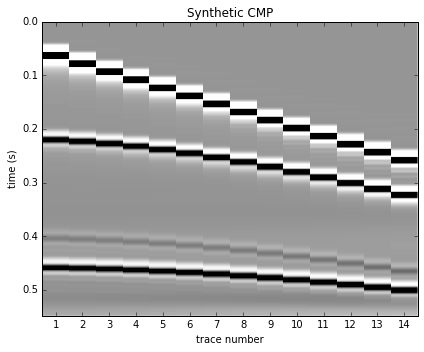

In [4]:
fig = plt.figure(figsize=(6,5))
ax = plt.subplot(111)
ax.set_title('Synthetic CMP')
ax.set_xlabel('trace number')
ax.set_ylabel('time (s)')
cutoff = 0.1
ax.imshow(cmp, extent=[0.5, noffsets + 0.5, dt*nsamples, 0], 
          aspect=20, cmap='Greys', vmin=-cutoff, vmax=cutoff, 
          interpolation='none')

trace_numbers = list(range(1, noffsets + 1))
ax.set_xticks(trace_numbers)
fig.tight_layout()

1. 直达波
2. 第一界面反射波
3. 第一个界面多次波
4. 第二个界面的反射波

## NMO correction

NMO correction的算法如下：

1. 从填充0的NMO道集开始
2. 对NMO道集中的每个点$(t_0, x)$ ：
    - 用给出的$v_{NMO}$计算反射走时
    - 在offset为$x$的CMP道中找到走时为$t$的前后各两个采样点
    - 如果$t$比记录时间大或者$t$后面没有两个采样点了，则跳过接下来的两步。
    - 用找到的四个采样点的振幅来插值得到时间$t$处的振幅
    - 将插值得到的振幅复制到NMO道集中$(t_0, x)$的位置

这里使用三个函数来实现整个算法，

In [5]:
def nmo_correction(cmp, dt, offsets, velocities):
    """
    Performs NMO correction on the given CMP.
    
    The units must be consistent. E.g., if dt is seconds and
    offsets is meters, velocities must be m/s.
    
    Parameters
    -----------
    
    cmp : 2D array
        The CMP gather that we want to corrent.
    dt : float
        The sampling interval.
    offsets : 1D array
        An array with the offset of each trace in the CMP.
    velocities  : 1D array
        An array with the NMO velocity for each time. Should
        have the same number of elements as the CMP has samples.
        
    Returns
    --------
    
    nmo : 2D array
        The NMO corrected gather.
    """
    nmo = np.zeros_like(cmp)
    nsamples = cmp.shape[0]
    times = np.arange(0, nsamples*dt, dt)
    for i, t0 in enumerate(times):
        for j, x in enumerate(offsets):
            t = reflection_time(t0, x, velocities[i])
            amplitude = sample_trace(cmp[:, j], t, dt)
            # If the time t is outsied of the CMP time
            # amplitude will be None.
            if amplitude is not None:
                nmo[i, j] = amplitude
    return nmo

现在我们可以实现具体的细节。首先，我们需要计算反射的走时:

$$
t = \sqrt { t_0^2 + \frac{ x^2 } {v_{NMO}^2} }
$$

In [19]:
def reflection_time(t0, x, vnmo):
    """
    Calculate the travel-time of a reflected wave.
    
    Doesn't consider refractions or changes in velocity.
    
    The units must be consistent. E.g., if t0 is seconds and
    x is meters, vnmo must be m/s.
    
    Parameters
    ----------
    
    t0 : float
        The zero-offset (normal incidence) travel-time.
    x : float
        The offset of the receiver.
    vnmo : float
        The NMO velocity.
        
    Return
    ------
    
    t : float
        The reflection travel-time.
    """
    t = np.sqrt(t0**2 + x**2/vnmo**2)
    return t

我们应先测试这个函数是否工作。办法就是用一个简单例子：若offset为0，那么$t$应该等于$t_0$

In [30]:
assert reflection_time(t0=4, x=0, vnmo=1000.) == 4, "Failed test"

并没有输出 "Failed test", 说明测试通过了。我们也可以通过可视化的方式来测试，正确的话，走时曲线应该是双曲型的。

我们知道第一层的真实速度为 4000m/s，而且中CMP 道集图上看，知道走时大概为0.2s.

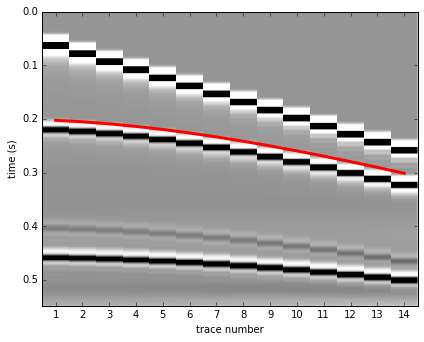

In [31]:
reflect_times = reflection_time(t0=0.2, x=offsets, vnmo=4000.)


fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax.set_xlabel('trace number')
ax.set_ylabel('time (s)')
cutoff = 0.1
ax.imshow(cmp, extent=[0.5, noffsets + 0.5, dt*nsamples, 0], 
          aspect=20, cmap='Greys', vmin=-cutoff, vmax=cutoff, 
          interpolation='none')
trace_numbers = list(range(1, noffsets + 1))
plt.plot(trace_numbers, reflect_times, '-r', linewidth=3)
ax.set_xticks(trace_numbers)
ax.set_ylim(nsamples*dt, 0)
ax.set_xlim(0.5, noffsets + 0.5)
fig.tight_layout()

看起来很合理。

最后的部分是最棘手的：在CMP中找到相应的时间点并做插值得到振幅。

In [34]:
def smaple_trace(trace, time, dt):
    """
    Sample an amplitude at a given time using interpolation.
    
    Parameters
    ----------
    
    trace : 1D array
        Array containing the amplitude of a single trace.
    time : float
        The time at which I want to sample the amplitude.
    dt : float
        The sampling interval
    
    Returns
    -------
    
    amplitude : float or None
        The interpolated amplitude. Will be None if *time*
        is beyond the end of the trace or if there are less
        than 2 points between *time* and the end.
    """
    # The floor function will given us the integer
    # right behind a given float.
    # Use it ti get the sample number that is right
    # before our desired time.
    before = int(np.floor(time/dt))
    N = trace.size
    # Use the 4 samples around time to interpolate
    smaples = np.arange(before -1, before + 3)
    if any(samples < 0) or any(samples > N):
        amplitude = None
    else:
        times = dt*samples
        amps = trace[samples]
        interpolator = CubicSpline(times, amps)
        amplitude = interpolator(time)
    return amplitude

TEST